In [107]:
import jax
import jax.numpy as jnp
import numpy as np # get rid of this eventually
import argparse
from jax import jit
from jax.experimental.ode import odeint
from functools import partial # reduces arguments to function by making some subset implicit

from jax.example_libraries import stax
from jax.experimental import optimizers

import os, sys, time
sys.path.append('..')
sys.path.append('../hyperopt')
from HyperparameterSearch import extended_mlp

In [108]:
from models import mlp as make_mlp
from utils import wrap_coords

In [109]:
from jax.experimental.ode import odeint

In [110]:
def hamiltonian_eom(hamiltonian, state, conditionals, t=None):
    q, p = jnp.split(state, 2)
    q = q / 10.0 #Normalize
    conditionals = conditionals / 10.0 #Normalize
    q_t = jax.grad(hamiltonian, 1)(q, p, conditionals)
    p_t = -jax.grad(hamiltonian, 0)(q, p, conditionals)
    
    q_tt = p_t #mass is 1
    return jnp.concatenate([q_t, q_tt])

# replace the lagrangian with a parameteric model
def learned_dynamics(params, nn_forward_fn):
    @jit
    def dynamics(q, p, conditionals):
        state = jnp.concatenate([q, p, conditionals])
        return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
    return dynamics

In [111]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

In [112]:
@jax.jit
def qdotdot(q, q_t, conditionals):
    g = conditionals
    
    q_tt = (
        g * (1 - q_t**2)**(5./2) / 
        (1 + 2 * q_t**2)
    )
    
    return q_t, q_tt

@jax.jit
def ofunc(y, t=None):
    q = y[::3]
    q_t = y[1::3]
    g = y[2::3]
    
    q_t, q_tt = qdotdot(q, q_t, g)
    return jnp.stack([q_t, q_tt, jnp.zeros_like(g)]).T.ravel()

In [113]:
(jnp.tanh(jax.random.uniform(jax.random.PRNGKey(1), (1000,))*10-5)*0.99999).max()

DeviceArray(0.99989885, dtype=float32)

In [114]:
from matplotlib import pyplot as plt

(array([30.,  8.,  5.,  8.,  3.,  2.,  5.,  3.,  5., 31.]),
 array([-9.9991339e-01, -7.9992497e-01, -5.9993654e-01, -3.9994809e-01,
        -1.9995967e-01,  2.8759241e-05,  2.0001718e-01,  4.0000561e-01,
         5.9999406e-01,  7.9998249e-01,  9.9997091e-01], dtype=float32),
 <a list of 10 Patch objects>)

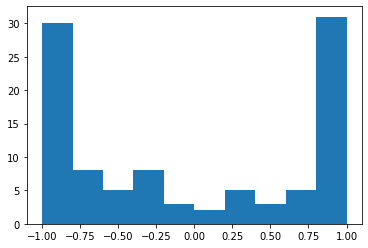

In [115]:
plt.hist((jnp.tanh(jax.random.normal(jax.random.PRNGKey(1), (100,))*2)*0.99999))

In [126]:
@partial(jax.jit, static_argnums=(1, 2), backend='cpu')
def gen_data(seed, batch, num):
    rng = jax.random.PRNGKey(seed)
    q0 = jax.random.uniform(rng, (batch,), minval=-10, maxval=10)
    qt0 = jax.random.uniform(rng+1, (batch,), minval=-0.99, maxval=0.99)
    g = jax.random.normal(rng+2, (batch,))*10

    y0 = jnp.stack([q0, qt0, g]).T.ravel()

    yt = odeint(ofunc, y0, jnp.linspace(0, 1, num=num), mxstep=300)

    qall = yt[:, ::3]
    qtall = yt[:, 1::3]
    gall = yt[:, 2::3]
    
    return jnp.stack([qall, qtall]).reshape(2, -1).T, gall.reshape(1, -1).T, qdotdot(qall, qtall, gall)[1].reshape(1, -1).T

@partial(jax.jit, static_argnums=(1,))
def gen_data_batch(seed, batch):
    rng = jax.random.PRNGKey(seed)
    q0 = jax.random.uniform(rng, (batch,), minval=-10, maxval=10)
    qt0 = (jnp.tanh(jax.random.normal(jax.random.PRNGKey(1), (batch,))*2)*0.99999)#jax.random.uniform(rng+1, (batch,), minval=-1, maxval=1)
    g = jax.random.normal(rng+2, (batch,))*10
    
    return jnp.stack([q0, qt0]).reshape(2, -1).T, g.reshape(1, -1).T, jnp.stack(qdotdot(q0, qt0, g)).T

In [129]:
cstate, cconditionals, ctarget = gen_data_batch(0, 5)
cstate, cconditionals, ctarget

(DeviceArray([[ 1.4900093 ,  0.9574616 ],
              [-8.006279  , -0.95951325],
              [-2.1367955 , -0.21696056],
              [ 7.883566  ,  0.6245134 ],
              [ 1.9313316 ,  0.33272812]], dtype=float32),
 DeviceArray([[ 5.672981  ],
              [13.351437  ],
              [ 3.9785006 ],
              [17.436966  ],
              [-0.24577108]], dtype=float32),
 DeviceArray([[ 0.9574616 ,  0.00400571],
              [-0.95951325,  0.00833027],
              [-0.21696056,  3.2232604 ],
              [ 0.6245134 ,  2.8466694 ],
              [ 0.33272812, -0.15006456]], dtype=float32))

In [130]:
from matplotlib import pyplot as plt

In [131]:
# qdotdot(jnp.array([0]), jnp.array([0.9]), jnp.array([10]))

In [132]:
# 0.29830917716026306 {'act': [4],
# 'batch_size': [27.0], 'dt': [0.09609870774790222],
# 'hidden_dim': [596.0], 'l2reg': [0.24927677946969878],
# 'layers': [4.0], 'lr': [0.005516656601005163],
# 'lr2': [1.897157209816416e-05], 'n_updates': [4.0]}

In [133]:
import pickle as pkl

In [134]:
# loaded = pkl.load(open('./params_for_loss_0.29429444670677185_nupdates=1.pkl', 'rb'))

In [135]:
args = ObjectView({'dataset_size': 200,
 'fps': 10,
 'samples': 100,
 'num_epochs': 80000,
 'seed': 0,
 'loss': 'l1',
 'act': 'softplus',
 'hidden_dim': 500,
 'output_dim': 1,
 'layers': 4,
 'n_updates': 1,
 'lr': 0.001,
 'lr2': 2e-05,
 'dt': 0.1,
 'model': 'gln',
 'batch_size': 68,
 'l2reg': 5.7e-07,
})
# args = loaded['args']
rng = jax.random.PRNGKey(args.seed)

In [142]:
from jax.experimental.ode import odeint

In [143]:
best_params = None
best_loss = np.inf

In [144]:
from itertools import product

In [145]:
init_random_params, nn_forward_fn = extended_mlp(args)
rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 3))
rng += 1


This is the output. Now, let's train it.

Idea: add identity before inverse:

# Let's train it:

In [146]:
best_small_loss = np.inf
iteration = 0
total_epochs = 100
minibatch_per = 3000
train_losses, test_losses = [], []

lr = 1e-3 #1e-3

final_div_factor=1e4

#OneCycleLR:
@jax.jit
def OneCycleLR(pct):
    #Rush it:
    start = 0.3 #0.2
    pct = pct * (1-start) + start
    high, low = lr, lr/final_div_factor
    
    scale = 1.0 - (jnp.cos(2 * jnp.pi * pct) + 1)/2
    
    return low + (high - low)*scale
    

opt_init, opt_update, get_params = optimizers.adam(
    OneCycleLR
)
opt_state = opt_init(init_params)
# opt_state = opt_init(best_params)

Text(0.5, 1.0, 'lr schedule')

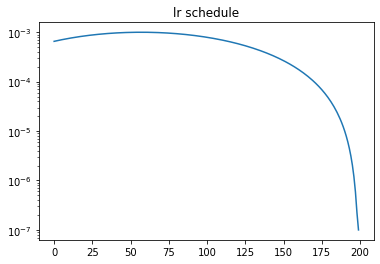

In [147]:
plt.plot(OneCycleLR(jnp.linspace(0, 1, num=200)))
plt.yscale('log')
plt.title('lr schedule')

In [152]:
from jax.tree_util import tree_flatten

@jax.jit
def loss(params, cstate, cconditionals, ctarget):
    runner = jax.vmap(
        partial(
            hamiltonian_eom,
            learned_dynamics(params, nn_forward_fn)), (0, 0), 0)
    preds = runner(cstate, cconditionals)[:, [0, 1]]
    
    error = jnp.abs(preds - ctarget)
    #Weight additionally by proximity to c!
    error_weights = (1 + 1/jnp.sqrt(1.0-cstate[:, [1]]**2))
    
    return jnp.sum(error * error_weights)*len(preds)/jnp.sum(error_weights)

@jax.jit
def update_derivative(i, opt_state, cstate, cconditionals, ctarget):
    params = get_params(opt_state)
    param_update = jax.grad(
            lambda *args: loss(*args)/len(cstate),
            0
        )(params, cstate, cconditionals, ctarget)
    params = get_params(opt_state)
    return opt_update(i, param_update, opt_state), params


In [153]:
epoch = 0

In [154]:
cstate, cconditionals, ctarget = gen_data_batch(epoch, 128)

In [155]:
loss(get_params(opt_state), cstate, cconditionals, ctarget)

DeviceArray(175.4566, dtype=float32)

In [156]:
update_derivative(0, opt_state, cstate, cconditionals, ctarget);

In [157]:
rng = jax.random.PRNGKey(0)

In [158]:
epoch = 0

In [159]:
from tqdm.notebook import tqdm

In [160]:
gen_data_batch(0, 128)[0].shape

(128, 2)

In [161]:
cconditionals[:5]

DeviceArray([[ -7.3825674 ],
             [  0.48637673],
             [  5.567146  ],
             [  3.391427  ],
             [-11.220732  ]], dtype=float32)

In [162]:
cstate[:5]

DeviceArray([[-8.077726  ,  0.13323684],
             [-2.589147  , -0.12181558],
             [-8.912823  ,  0.9635672 ],
             [ 4.5006466 ,  0.9999864 ],
             [ 6.4032707 ,  0.98424286]], dtype=float32)

In [163]:
ctarget[:5]

DeviceArray([[ 1.3323684e-01, -6.8172374e+00],
             [-1.2181558e-01,  4.5502922e-01],
             [ 9.6356720e-01,  2.6673502e-03],
             [ 9.9998641e-01,  4.3539304e-12],
             [ 9.8424286e-01, -6.6027965e-04]], dtype=float32)

In [164]:
best_loss = np.inf
best_params = None

In [165]:
from copy import deepcopy as copy

In [166]:
for epoch in tqdm(range(epoch, total_epochs)):
    epoch_loss = 0.0
    num_samples = 0
    batch = 512
    ocstate, occonditionals, octarget = gen_data_batch(epoch, minibatch_per*batch)
    for minibatch in range(minibatch_per):
        fraction = (epoch + minibatch/minibatch_per)/total_epochs
        s = np.s_[minibatch*batch:(minibatch+1)*batch]
        
        cstate, cconditionals, ctarget = ocstate[s], occonditionals[s], octarget[s]
        opt_state, params = update_derivative(fraction, opt_state, cstate, cconditionals, ctarget);
        rng += 10
        
        cur_loss = loss(params, cstate, cconditionals, ctarget)
        
        epoch_loss += cur_loss
        num_samples += len(cstate)
    closs = epoch_loss/num_samples
    print('epoch={} lr={} loss={}'.format(
        epoch, OneCycleLR(fraction), closs)
         )
    if closs < best_loss:
        best_loss = closs
        best_params = [[copy(jax.device_get(l2)) for l2 in l1] if len(l1) > 0 else () for l1 in params]

epoch=0 lr=0.0006752928602509201 loss=0.4576779007911682
epoch=1 lr=0.0006957106525078416 loss=0.4278222322463989
epoch=2 lr=0.0007157498621381819 loss=0.42640888690948486
epoch=3 lr=0.0007353719556704164 loss=0.4248338043689728
epoch=4 lr=0.0007545390981249511 loss=0.4242565929889679
epoch=5 lr=0.000773213803768158 loss=0.4227651357650757
epoch=6 lr=0.0007913602748885751 loss=0.42145994305610657
epoch=7 lr=0.0008089432376436889 loss=0.42091017961502075
epoch=8 lr=0.0008259288733825088 loss=0.4207681119441986
epoch=9 lr=0.0008422840619459748 loss=0.41996580362319946
epoch=10 lr=0.0008579773711971939 loss=0.4197915494441986
epoch=11 lr=0.000872978416737169 loss=0.41876354813575745
epoch=12 lr=0.0008872582111507654 loss=0.41935107111930847
epoch=13 lr=0.0009007891057990491 loss=0.41843855381011963
epoch=14 lr=0.0009135449072346091 loss=0.4186243414878845
epoch=15 lr=0.0009255009354092181 loss=0.4181230068206787
epoch=16 lr=0.0009366340818814933 loss=0.41830745339393616
epoch=17 lr=0.0009

In [167]:
import pickle as pkl

In [169]:
# pkl.dump({'params': best_params, 'description': 'q and g are divided by 10. hidden=500. act=Softplus'},
#          open('best_sr_params_hamiltonian.pkl', 'wb'))

In [170]:
opt_state = opt_init(best_params)

In [171]:
cstate, cconditionals, ctarget = gen_data(0, 1, 50)

In [172]:
cstate.shape

(50, 2)

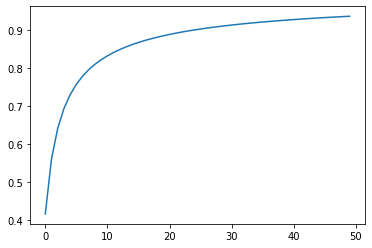

In [173]:
plt.plot(cstate[:, 1])

In [174]:
params = get_params(opt_state)

In [179]:
plt.rc('font', family='serif')

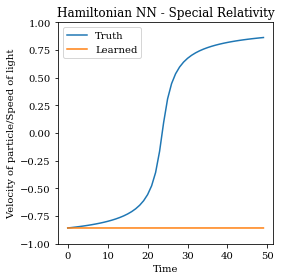

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(4*1, 4*1), sharex=True, sharey=True)
ax_idx = [(i, j) for i in range(1) for j in range(1)]

for i in tqdm(range(1)):
    
    ci = ax_idx[i]
    
    cstate, cconditionals, ctarget = gen_data((i+4)*(i+1), 1, 50)
    
    runner = jax.jit(jax.vmap(
        partial(
            hamiltonian_eom,
            learned_dynamics(params, nn_forward_fn)), (0, 0), 0))

    @jax.jit
    def odefunc_learned(y, t):
        return jnp.concatenate((runner(y[None, :2], y[None, [2]])[0], jnp.zeros(1)))

    yt_learned = odeint(
        odefunc_learned,
        jnp.concatenate([cstate[0], cconditionals[0]]),
        np.linspace(0, 1, 50),
        mxstep=100)
    
    cax = ax#[ci[0], ci[1]]
    cax.plot(cstate[:, 1], label='Truth')
    cax.plot(yt_learned[:, 1], label='Learned')
    cax.legend()
    if ci[1] == 0:
        cax.set_ylabel('Velocity of particle/Speed of light')
    if ci[0] == 0:
        cax.set_xlabel('Time')
        
    cax.set_ylim(-1, 1)
    
plt.title("Hamiltonian NN - Special Relativity")
plt.tight_layout()
plt.savefig('sr_hnn.png', dpi=150)